<div style="text-align:left; width:95%; border-radius:12px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A7C9DB; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h2 style="margin: 0">Apache Spark session start</h2>
</div>

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
MAX_MEMORY = "5g"

spark = SparkSession.builder\
            .appName("project")\
            .master("local[*]")\
            .config("spark.sql.shuffle.partitions", "5")\
            .config('spark.sql.warehouse.dir', 'file:///C:/Users/chaewon/OneDrive/JNU/Graduate\x824/Second semester/Advanced Big Data Analysis/Term project/project_code/')\
            .config("spark.executor.memory", MAX_MEMORY)\
            .config("spark.driver.memory", MAX_MEMORY)\
            .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

spark

<div style="text-align:left; width:95%; border-radius:12px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A7C9DB; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h2 style="margin: 0">Data preprocessing</h2>
</div>

<div style="text-align:left; width:95%; border-radius:12px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3 style="margin: 0">Import Modules</h3>
</div>

In [4]:
# from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer

from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline


import warnings
warnings.filterwarnings("ignore")

In [5]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

In [6]:
# csv file paths
train_path = "brist1d/train.csv"
test_path = "brist1d/test.csv"
subm_path = "brist1d/sample_submission.csv"

# Load the data
df_train = spark.read.csv(train_path, header=True, inferSchema=True)
df_test = spark.read.csv(test_path, header=True, inferSchema=True)
df_subm = spark.read.csv(subm_path, header=True, inferSchema=True)

In [7]:
# time 컬럼을 timestamp로 변환
df_train = df_train.withColumn('time', to_timestamp(df_train['time']))
df_test = df_test.withColumn('time', to_timestamp(df_test['time']))

In [8]:
# 컬럼 이름의 ':'를 '-'로 변경
df_train = df_train.toDF(*[col.replace(':', '-') for col in df_train.columns])
df_test = df_test.toDF(*[col.replace(':', '-') for col in df_test.columns])

# 확인
df_train.printSchema()
df_test.printSchema()

root
 |-- id: string (nullable = true)
 |-- p_num: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- bg-5-55: double (nullable = true)
 |-- bg-5-50: double (nullable = true)
 |-- bg-5-45: double (nullable = true)
 |-- bg-5-40: double (nullable = true)
 |-- bg-5-35: double (nullable = true)
 |-- bg-5-30: double (nullable = true)
 |-- bg-5-25: double (nullable = true)
 |-- bg-5-20: double (nullable = true)
 |-- bg-5-15: double (nullable = true)
 |-- bg-5-10: double (nullable = true)
 |-- bg-5-05: double (nullable = true)
 |-- bg-5-00: double (nullable = true)
 |-- bg-4-55: double (nullable = true)
 |-- bg-4-50: double (nullable = true)
 |-- bg-4-45: double (nullable = true)
 |-- bg-4-40: double (nullable = true)
 |-- bg-4-35: double (nullable = true)
 |-- bg-4-30: double (nullable = true)
 |-- bg-4-25: double (nullable = true)
 |-- bg-4-20: double (nullable = true)
 |-- bg-4-15: double (nullable = true)
 |-- bg-4-10: double (nullable = true)
 |-- bg-4-05: double (nulla

<div style="text-align:left; width:95%; border-radius:12px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Interpolation Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)</div>
</div>

In [9]:
# 각 컬럼에 대해 선형 보간법을 적용하는 함수
def linear_interpolate(df, colset):
    for col in colset:
        # 창을 정의하여 각 그룹별로 순차적으로 보간을 진행
        window_spec = Window.orderBy("time")  # 'time' 컬럼을 기준으로 정렬

        # 앞뒤 값을 가져오는 lag와 lead 함수 사용
        lag_col = F.lag(col).over(window_spec)
        lead_col = F.lead(col).over(window_spec)

        # 결측값을 앞뒤 값으로 선형 보간
        df = df.withColumn(
            col,
            F.coalesce(
                F.col(col),  # 기존 값이 있으면 그대로 사용
                (lag_col + lead_col) / 2,  # 앞뒤 값을 평균으로 보간
            ),
        )
    return df


# 예시: 컬럼 리스트 (여기서는 bg_cols, insu_cols 등)
colsets = [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]

# 각 컬럼에 대해 선형 보간법 적용
for colset in colsets:
    df_train = linear_interpolate(df_train, colset)
    df_test = linear_interpolate(df_test, colset)

In [10]:
# 결과 확인
df_train = df_train.orderBy("id")
df_test = df_test.orderBy("id")

df_train.show(n=3)
df_test.show(n=3)

+------+-----+-------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+

<div style="text-align:left; width:95%; border-radius:12px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>

In [11]:
from pyspark.sql import functions as F

# feature_cols: 결측값을 대체할 컬럼 리스트
# df_train: 학습 데이터프레임
# df_test: 테스트 데이터프레임

# 1. df_train에서 각 컬럼의 평균값 계산
mean_values = df_train.select([F.mean(col).alias(col) for col in feature_cols]).collect()[0].asDict()

# 2. 결측값을 각 컬럼의 평균값으로 대체
for col in feature_cols:
    df_train = df_train.withColumn(col, F.coalesce(F.col(col), F.lit(mean_values[col])))
    df_test = df_test.withColumn(col, F.coalesce(F.col(col), F.lit(mean_values[col])))

# 결과 확인
df_train.show(n=3)
df_test.show(n=3)

+------+-----+-------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-----------------+-----------------+-------+-----------------+-----------------+-------+-----------------+-----------------+-------+-----------------+-----------------+-------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----------

<div style="text-align:left; width:95%; border-radius:12px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Time Features</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)</div>
</div>

In [12]:
# 1. hour 컬럼 계산
df_train = df_train.withColumn('hour', F.hour(df_train[date_col]))
df_test = df_test.withColumn('hour', F.hour(df_test[date_col]))

# 2. sin, cos 값 계산
df_train = df_train.withColumn('sin_hour', F.sin(F.lit(np.pi) * df_train['hour'] / 12))
df_train = df_train.withColumn('cos_hour', F.cos(F.lit(np.pi) * df_train['hour'] / 12))

df_test = df_test.withColumn('sin_hour', F.sin(F.lit(np.pi) * df_test['hour'] / 12))
df_test = df_test.withColumn('cos_hour', F.cos(F.lit(np.pi) * df_test['hour'] / 12))

# 3. feature_cols에 추가
feature_cols.extend(['sin_hour', 'cos_hour'])

# 결과 확인
df_train.show(n=3)
df_test.show(n=3)

+------+-----+-------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-----------------+-----------------+-------+-----------------+-----------------+-------+-----------------+-----------------+-------+-----------------+-----------------+-------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----------

<div style="text-align:left; width:95%; border-radius:12px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Grouped Features</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data</div>
</div>

In [13]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

# 결과 출력
print(grouped_features)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]]


<div style="text-align:left; width:95%; border-radius:12px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A7C9DB; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h2 style="margin: 0">Training & Inference</h2>
</div>

In [14]:
# 예측 결과 저장을 위한 DataFrame 생성
df_subm = df_subm.withColumn('bg+1:00', F.lit(0.0))

# Feature columns 준비
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_train = assembler.transform(df_train)
df_test = assembler.transform(df_test)

<div style="text-align:left; width:95%; border-radius:12px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3 style="margin: 0">Models using individual features</h3>
</div>

#### 1. GBTRegressor

In [15]:
# GBTRegressor 모델 설정
reg = GBTRegressor(featuresCol="features", labelCol=target_col, maxBins=64, maxDepth=10, maxIter=20, stepSize=0.1)

# 모델 학습
model = reg.fit(df_train)

# 테스트 데이터에 대해 예측 수행
predictions = model.transform(df_test).select("id", "prediction")

# 예측값을 df_subm에 업데이트
df_subm = df_subm.alias("subm").join(
    predictions.alias("pred"),
    on="id",
    how="left"
).withColumn(
    "bg+1:00",
    F.when(F.col("pred.prediction").isNotNull(), F.col("pred.prediction")).otherwise(F.col("subm.bg+1:00"))
).select("id", "bg+1:00")  # 필요한 컬럼만 선택

# 결과 확인 및 저장
df_subm.show(n=3)  # 결과 확인
df_subm.toPandas().to_csv('submission_GBT.csv', index=False)

+--------+------------------+
|      id|           bg+1:00|
+--------+------------------+
|p01_8459|11.407938138772105|
|p01_8460| 5.725161313743638|
|p01_8461| 7.446622660015689|
+--------+------------------+
only showing top 3 rows



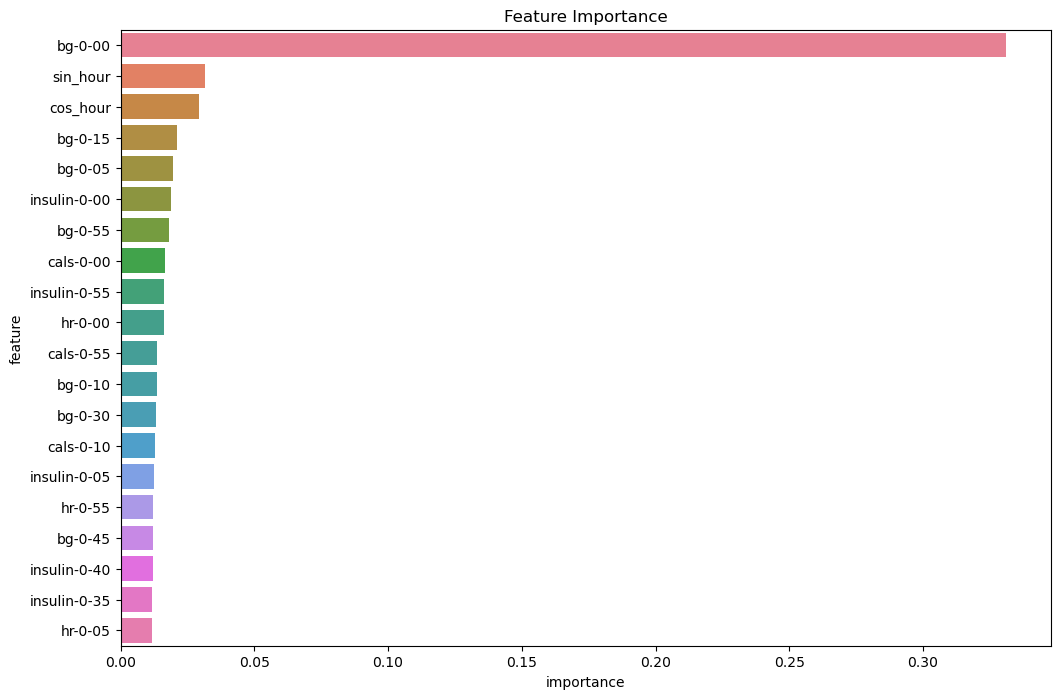

In [16]:
# 특성 중요도 추출
importances = model.featureImportances
feature_importances = [(feature, importance) for feature, importance in zip(feature_cols, importances)]
feature_importances = sorted(feature_importances, key=lambda x: -x[1])

# Pandas DataFrame으로 변환
importance_df = pd.DataFrame(feature_importances, columns=["feature", "importance"])

# 상위 20개 특성 시각화
plt.figure(figsize=(12, 8))
sns.barplot(
    y=importance_df["feature"][0:20],
    x=importance_df["importance"][0:20],
    palette="husl",
)
plt.title("Feature Importance")
plt.savefig('feature_importance_GBT.png', dpi=300)
plt.show()

#### 2. Decision Tree Regressor

In [17]:
# Decision tree 모델 설정
dt = DecisionTreeRegressor(featuresCol="features", labelCol=target_col)

# 모델 학습
model = dt.fit(df_train)

# 테스트 데이터에 대해 예측 수행
predictions = model.transform(df_test).select("id", "prediction")

# 예측값을 df_subm에 업데이트
df_subm = df_subm.alias("subm").join(
    predictions.alias("pred"),
    on="id",
    how="left"
).withColumn(
    "bg+1:00",
    F.when(F.col("pred.prediction").isNotNull(), F.col("pred.prediction")).otherwise(F.col("subm.bg+1:00"))
).select("id", "bg+1:00")  # 필요한 컬럼만 선택

# 결과 확인 및 저장
df_subm.show(n=3)  # 결과 확인
df_subm.toPandas().to_csv('submission_DT.csv', index=False)

+--------+-----------------+
|      id|          bg+1:00|
+--------+-----------------+
|p01_8459|9.538837628592706|
|p01_8460|6.643277182235867|
|p01_8461|7.498109586412075|
+--------+-----------------+
only showing top 3 rows



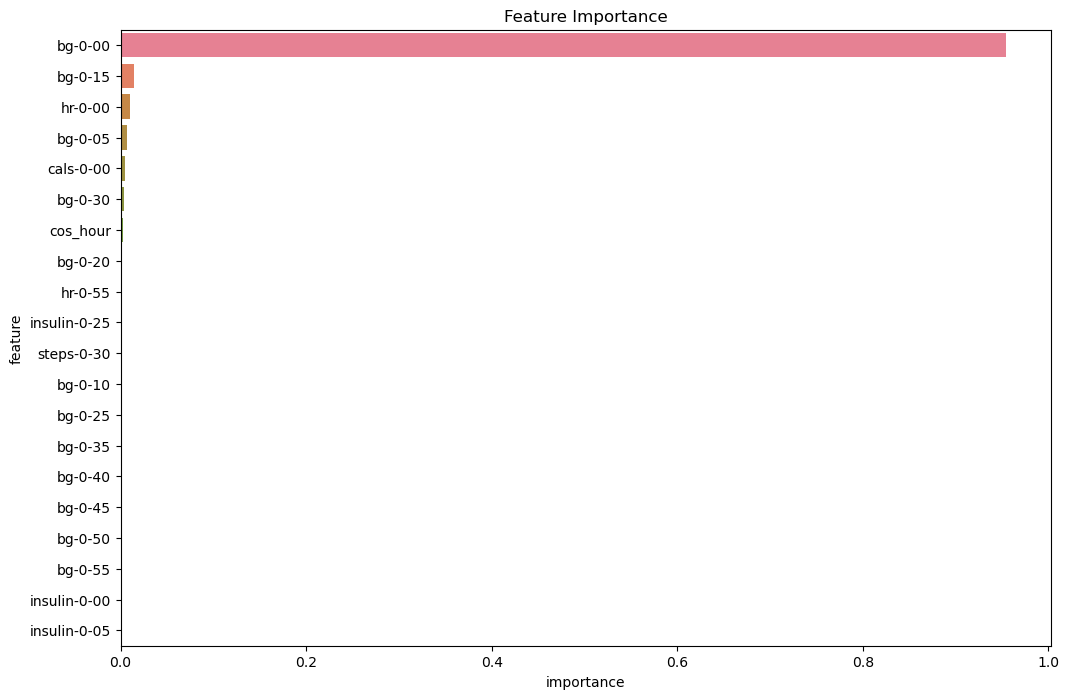

In [18]:
# 특성 중요도 추출
importances = model.featureImportances
feature_importances = [(feature, importance) for feature, importance in zip(feature_cols, importances)]
feature_importances = sorted(feature_importances, key=lambda x: -x[1])

# Pandas DataFrame으로 변환
importance_df = pd.DataFrame(feature_importances, columns=["feature", "importance"])

# 상위 20개 특성 시각화
plt.figure(figsize=(12, 8))
sns.barplot(
    y=importance_df["feature"][0:20],
    x=importance_df["importance"][0:20],
    palette="husl",
)
plt.title("Feature Importance")
plt.savefig('feature_importance_DT.png', dpi=300)
plt.show()

#### 3. Linear Regression

In [19]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Linear Regression
lr = LinearRegression(
    featuresCol="features",
    labelCol=target_col,  # Replace `target_col` with your target column name
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0  # Set to 0.0 for L2 regularization
)

# Train the model
model = lr.fit(df_train)

# Make predictions on the validation set
predictions = model.transform(df_test)


# (Optional) Show a few predictions
df_subm = predictions.select("id", "prediction")
# change the column name from prediction to bg+1:00
df_subm = df_subm.withColumnRenamed("prediction", "bg+1:00")

df_subm.show(n=3)
df_subm.toPandas().to_csv('submission_LR.csv', index=False)

+--------+-----------------+
|      id|          bg+1:00|
+--------+-----------------+
|p01_8459|8.914784944777754|
|p01_8460|4.377708170816516|
|p01_8461|8.106599691534132|
+--------+-----------------+
only showing top 3 rows



<div style="text-align:left; width:95%; border-radius:12px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3 style="margin: 0">Models using grouped features</h3>
</div>

In [20]:
def aggregate_group_features(df, feature_cols, grouped_features, aggregation="mean"):
    for i, group in enumerate(grouped_features):
        group_col_names = [feature_cols[idx] for idx in group]
        group_col_agg = f"group_{i}_{aggregation}"
        
        if aggregation == "mean":
            # Calculate mean for each group
            df = df.withColumn(
                group_col_agg, 
                sum(F.col(col) for col in group_col_names) / len(group_col_names)
            )
        elif aggregation == "sum":
            # Calculate sum for each group
            df = df.withColumn(
                group_col_agg, 
                sum(F.col(col) for col in group_col_names)
            )
        else:
            raise ValueError("Unsupported aggregation function.")
    
    return df

# Aggregate grouped features in the training and testing datasets
df_train = aggregate_group_features(df_train, feature_cols, grouped_features, aggregation="mean")
df_test = aggregate_group_features(df_test, feature_cols, grouped_features, aggregation="mean")

# Extract aggregated group column names
aggregated_group_cols = [f"group_{i}_mean" for i in range(len(grouped_features))]

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=aggregated_group_cols, outputCol="grouped_features")
df_train = assembler.transform(df_train)
df_test = assembler.transform(df_test)

#### 1. GBTRegressor

In [21]:
# Train the GBTRegressor
reg = GBTRegressor(featuresCol="grouped_features", labelCol=target_col)
model = reg.fit(df_train)

# Make predictions on the test data
predictions = model.transform(df_test).select("id", "prediction")

# Update `df_subm` with predictions
df_subm = df_subm.alias("subm").join(
    predictions.alias("pred"),
    on="id",
    how="left"
).withColumn(
    "bg+1:00",
    F.when(F.col("pred.prediction").isNotNull(), F.col("pred.prediction")).otherwise(F.col("subm.bg+1:00"))
).select("id", "bg+1:00")

# Display the results
df_subm.show(n=3)
df_subm.toPandas().to_csv('submission_GBT_grouped.csv', index=False)

+--------+-----------------+
|      id|          bg+1:00|
+--------+-----------------+
|p01_8459|  9.3400307080608|
|p01_8460|7.223610943873845|
|p01_8461|7.780873946019211|
+--------+-----------------+
only showing top 3 rows



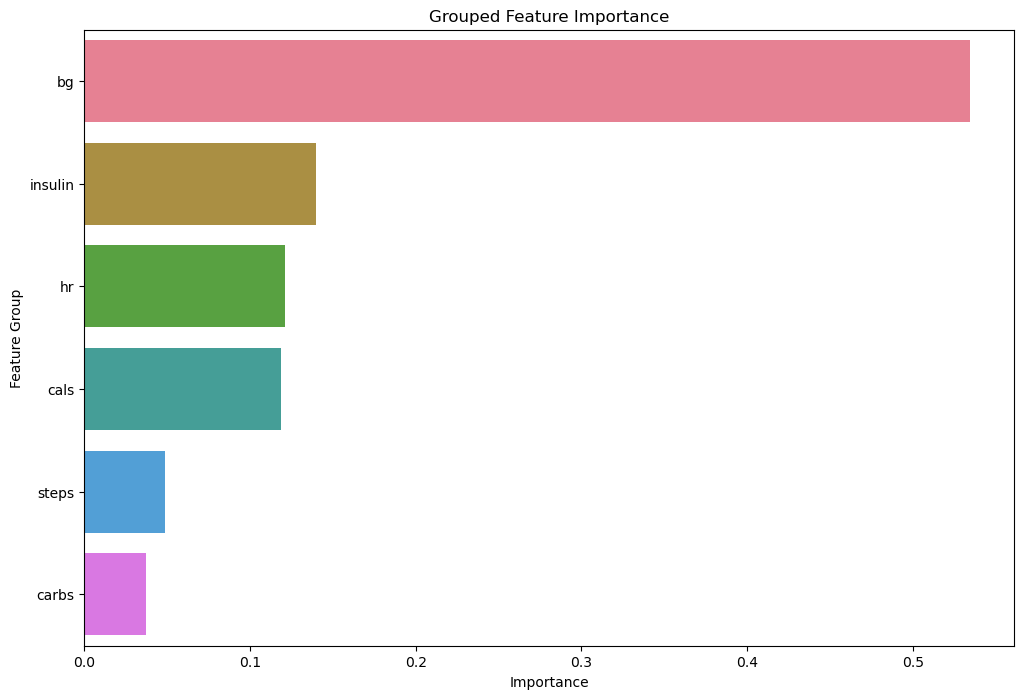

In [23]:
importances = model.featureImportances
# Group names for better clarity
group_names = ["bg", "insulin", "carbs", "hr", "steps", "cals"]

# Grouped feature importance 계산
group_importances = []
for idx, group_name in enumerate(group_names):
    group_importance = importances[idx]
    group_importances.append((group_name, group_importance))

# 중요도 내림차순으로 정렬
group_importances = sorted(group_importances, key=lambda x: -x[1])

# Pandas DataFrame으로 변환
group_importance_df = pd.DataFrame(group_importances, columns=["group", "importance"])

# 상위 20개 그룹 시각화
plt.figure(figsize=(12, 8))
sns.barplot(
    y=group_importance_df["group"][0:20],
    x=group_importance_df["importance"][0:20],
    palette="husl",
)
plt.title("Grouped Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature Group")
plt.savefig("grouped_feature_importance_GBT.png", dpi=300)
plt.show()

#### 2. Decision Tree Regressor

In [24]:
# Decision tree 모델 설정
reg = DecisionTreeRegressor(featuresCol="grouped_features", labelCol=target_col)

# 모델 학습
model = reg.fit(df_train)

# 테스트 데이터에 대해 예측 수행
predictions = model.transform(df_test).select("id", "prediction")

# 예측값을 df_subm에 업데이트
df_subm = df_subm.alias("subm").join(
    predictions.alias("pred"),
    on="id",
    how="left"
).withColumn(
    "bg+1:00",
    F.when(F.col("pred.prediction").isNotNull(), F.col("pred.prediction")).otherwise(F.col("subm.bg+1:00"))
).select("id", "bg+1:00")  # 필요한 컬럼만 선택

# 결과 확인 및 저장
df_subm.show(n=3)  # 결과 확인
df_subm.toPandas().to_csv('submission_DT_grouped.csv', index=False)

+--------+-----------------+
|      id|          bg+1:00|
+--------+-----------------+
|p01_8459|9.083064466662647|
|p01_8460|7.377833248162246|
|p01_8461| 7.99857375713122|
+--------+-----------------+
only showing top 3 rows



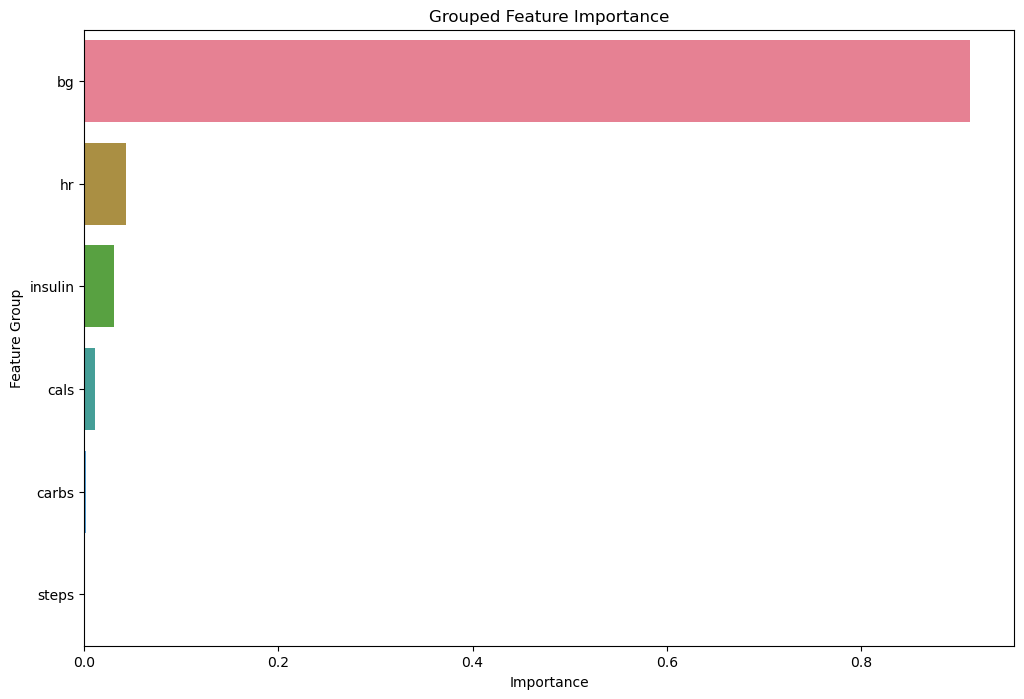

In [25]:
importances = model.featureImportances

# Group names for better clarity
group_names = ["bg", "insulin", "carbs", "hr", "steps", "cals"]

# Grouped feature importance 계산
group_importances = []
for idx, group_name in enumerate(group_names):
    group_importance = importances[idx]
    group_importances.append((group_name, group_importance))

# 중요도 내림차순으로 정렬
group_importances = sorted(group_importances, key=lambda x: -x[1])

# Pandas DataFrame으로 변환
group_importance_df = pd.DataFrame(group_importances, columns=["group", "importance"])

# 상위 20개 그룹 시각화
plt.figure(figsize=(12, 8))
sns.barplot(
    y=group_importance_df["group"][0:20],
    x=group_importance_df["importance"][0:20],
    palette="husl",
)
plt.title("Grouped Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature Group")
plt.savefig("grouped_feature_importance_DT.png", dpi=300)
plt.show()

#### 3. Linear Regression

In [26]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

# features 컬럼이 있다면 제거
df_train = df_train.drop("grouped_features")
df_test = df_test.drop("grouped_features")

# LinearRegression 모델 정의
lr = LinearRegression(
    labelCol=target_col,
    featuresCol="grouped_features",
    maxIter=100,
    elasticNetParam=0.0  # Ridge regression (L2 regularization)
)

# 평가 지표 정의
evaluator = RegressionEvaluator(
    labelCol=target_col,
    predictionCol="prediction",
    metricName="rmse"
)

# 파라미터 그리드 설정
# LinearRegression의 주요 하이퍼파라미터들
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
    

# 파이프라인 생성
pipeline = Pipeline(stages=[
    assembler,  # VectorAssembler
    lr         # LinearRegression
])

# 교차 검증 설정
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=2
)

# 교차 검증 수행
print("Starting cross validation...")
cv_model = crossval.fit(df_train)
print("Cross validation completed!")

# 최종 모델로 예측
print("Making predictions...")
predictions = cv_model.transform(df_test)

# 교차 검증 결과 확인
avg_rmse = cv_model.avgMetrics[0]
print(f"\nAverage RMSE across folds: {avg_rmse}")

# 각 폴드별 성능 확인
print("\nPerformance for each parameter combination:")
for i, metric in enumerate(cv_model.avgMetrics):
    params = paramGrid[i]
    reg_param = params[lr.regParam]
    elastic_param = params[lr.elasticNetParam]
    print(f"RegParam: {reg_param}, ElasticNetParam: {elastic_param}, RMSE: {metric}")

# 최적 모델의 계수와 절편 출력
best_model = cv_model.bestModel
best_lr = best_model.stages[-1]
print("\nBest model parameters:")
print(f"Regularization Parameter: {best_lr.getRegParam()}")
print(f"ElasticNet Parameter: {best_lr.getElasticNetParam()}")
print(f"Intercept: {best_lr.intercept}")

# 특성 중요도(계수) 확인
feature_importance = list(zip(group_col, best_lr.coefficients))
print("\nFeature coefficients:")
for feature, coef in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)[:10]:
    print(f"{feature}: {coef}")

# 예측 결과를 submission 형식으로 변환
predictions_for_submission = predictions.select("id", "prediction").withColumnRenamed("prediction", "bg+1:00")

# 결과 저장
predictions_for_submission.toPandas().to_csv('submission_LR_with_CV.csv', index=False)

Starting cross validation...
Cross validation completed!
Making predictions...

Average RMSE across folds: 2.488606760586813

Performance for each parameter combination:
RegParam: 0.01, ElasticNetParam: 0.0, RMSE: 2.488606760586813
RegParam: 0.01, ElasticNetParam: 0.5, RMSE: 2.4886164322086857
RegParam: 0.01, ElasticNetParam: 1.0, RMSE: 2.488697077039631
RegParam: 0.1, ElasticNetParam: 0.0, RMSE: 2.489182029337652
RegParam: 0.1, ElasticNetParam: 0.5, RMSE: 2.4919089404673107
RegParam: 0.1, ElasticNetParam: 1.0, RMSE: 2.4939429555962898
RegParam: 1.0, ElasticNetParam: 0.0, RMSE: 2.522582084612013
RegParam: 1.0, ElasticNetParam: 0.5, RMSE: 2.5795128911316376
RegParam: 1.0, ElasticNetParam: 1.0, RMSE: 2.6851000048536795

Best model parameters:
Regularization Parameter: 0.01
ElasticNet Parameter: 0.0
Intercept: 2.435522069441569

Feature coefficients:
p: 0.6371769197306473
_: 0.20530626160067003
u: 0.009513521827152299
n: -0.0007270944162355807
m: -0.00011033709914142285


In [28]:
def aggregate_group_features(df, feature_cols, grouped_features, aggregation="mean"):
    for i, group in enumerate(grouped_features):
        group_col_names = [feature_cols[idx] for idx in group]
        group_col_agg = f"group_{i}_{aggregation}"
        
        if aggregation == "mean":
            # Calculate mean for each group
            df = df.withColumn(
                group_col_agg, 
                sum(F.col(col) for col in group_col_names) / len(group_col_names)
            )
        elif aggregation == "sum":
            # Calculate sum for each group
            df = df.withColumn(
                group_col_agg, 
                sum(F.col(col) for col in group_col_names)
            )
        else:
            raise ValueError("Unsupported aggregation function.")
    
    return df

# Aggregate grouped features in the training and testing datasets
df_train = aggregate_group_features(df_train, feature_cols, grouped_features, aggregation="mean")
df_test = aggregate_group_features(df_test, feature_cols, grouped_features, aggregation="mean")

# Extract aggregated group column names
aggregated_group_cols = [f"group_{i}_mean" for i in range(len(grouped_features))]

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=aggregated_group_cols, outputCol="grouped_features")
df_train = assembler.transform(df_train)
df_test = assembler.transform(df_test)

In [29]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Linear Regression
lr = LinearRegression(
    featuresCol="grouped_features",
    labelCol=target_col,  # Replace `target_col` with your target column name
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.5  # Set to 0.0 for L2 regularization
)

# Train the model
model = lr.fit(df_train)

# Make predictions on the validation set
predictions = model.transform(df_test)


# (Optional) Show a few predictions
df_subm = predictions.select("id", "prediction")
# change the column name from prediction to bg+1:00
df_subm = df_subm.withColumnRenamed("prediction", "bg+1:00")

df_subm.show(n=3)
df_subm.toPandas().to_csv('submission_LR_bestparams.csv', index=False)

+--------+-----------------+
|      id|          bg+1:00|
+--------+-----------------+
|p01_8459|8.594445481755823|
|p01_8460|7.716584066339194|
|p01_8461|8.108964162783884|
+--------+-----------------+
only showing top 3 rows

